# Analyzing Extreme Precipitation Rates using the GES DISC GPM Giovanni Cache Zarr Store

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Warning:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

<p></p>

### Overview

This notebook demonstrates how to access the Giovanni Cache Zarr Store [S3 bucket](https://disc.gsfc.nasa.gov/information/faqs?keywords=%22earthdata%20cloud%22&title=What%20is%20S3%20access%3F) inside the [AWS us-west-2](https://disc.gsfc.nasa.gov/information/documents?title=Migrating%20to%20the%20Cloud) region for performing analysis. It accesses the [GPM IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V06 precipitationCal](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_06/summary?keywords=GPM_3IMERGHH_06) variable Zarr Store, then subsets it over Northern California (`[-124.295,38.954,-119.989,42.03]`) and Southern California (`[-117.45,33.7939,-115.95,35.7275]`) for the months of February/August between 2002-2017 and 2001-2021. Finally, it compares and plots daily average precipitation rates, and anomalous precipitation rates, between these spatiotemporal regions.

The displayed times are the results of running this notebook in an EC2 instance with 3.75 CPU cores, and 14.85 GB of RAM.

### Prerequisites

This notebook was written using Python 3.10, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- Dask
- requests
- S3FS
- Boto3
- NumPy
- Matplotlib
- Cartopy (optional, used for plotting bounding boxes)
- HVPlot
- Pandas

### 1. Import Modules

In [1]:
import s3fs
import boto3
import requests
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import hvplot.xarray
import panel as pn

from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### 2. Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

### 3. Read in Zarr store with temporary credentials and xarray

Retrieve 1-hour token from the Giovanni AWS Lambda API:

In [3]:
def retrieve_credentials():
    """Makes the Oauth calls to authenticate with EDS and return a set of s3 same-region, read-only credentials."""
    response = requests.get("https://api.giovanni.earthdata.nasa.gov/s3credentials")
    response.raise_for_status()
    return response.json()

Retrieve Zarr store using the token credentials, open with S3FS

In [4]:
def get_zarr_store():
    """Create an S3ZarrStore for the GPM_3IMERGHH_06_precipitationCal variable."""
    creds = retrieve_credentials()
    bucket_name = "prod-giovanni-cache"
    bucket_path = "zarr/GPM_3IMERGHH_06_precipitationCal"

    s3 = s3fs.S3FileSystem(key=creds["AccessKeyId"], 
                           secret=creds["SecretAccessKey"], 
                           token=creds["SessionToken"])

    store = s3.get_mapper(f"{bucket_name}/{bucket_path}")
    return store

In [5]:
store = get_zarr_store()

Open and display the Zarr store metadata

In [6]:
%%time
data = xr.open_zarr(store=store, consolidated=False)
data

CPU times: user 3.97 s, sys: 142 ms, total: 4.12 s
Wall time: 18 s


<xarray.Dataset>
Dimensions:      (latitude: 1800, longitude: 3600, time: 374200, bounds: 2)
Coordinates:
  * latitude     (latitude) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * longitude    (longitude) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time         (time) datetime64[s] 2000-06-01 ... 2000-05-31T23:00:00
Dimensions without coordinates: bounds
Data variables:
    time_bounds  (time, bounds) datetime64[s] dask.array<chunksize=(200, 2), meta=np.ndarray>
    variable     (latitude, longitude, time) float32 dask.array<chunksize=(36, 72, 200), meta=np.ndarray>

### 4. Mask and drop where there are fill values (`numpy.datetime64('2000-05-31T23:00:00')`)

In [7]:
data_masked_dropped = data.where(data["time"] != data["time"]._FillValue, drop=True)

### 5. Define function for calculating weighted area averages per year with [Dask Delayed](https://docs.dask.org/en/stable/delayed.html)

In [8]:

@dask.delayed
def process_year(time_slice, data_subset):
    """
    Process and calculate the weighted average for a specific year's month slice.

    The function is decorated with @dask.delayed to allow for potential parallel execution 
    when used with Dask's delayed functions.

    Parameters:
    time_slice (tuple): The date range for calculations.
    
    data_subset (xarray.Dataset): The dataset containing the variable of interest along with 
                                  coordinates and time values.
    Returns:
    xarray.DataArray: A DataArray containing the latitude-weighted averages of the 'variable' 
                      for each day in the passed time range of the specified year. 
                      The data is grouped by day with the 'year' coordinate attached for identification.

    """
    
    # Select the data for the year
    data = data_subset.sel(time=time_slice)

    # Shift the time by 12 hours to avoid the discontinuity at midnight
    data['time'] = data.indexes['time'] + pd.to_timedelta(12, unit='h')

    # Calculate the weights
    lat_weights = np.cos(np.pi*data.latitude/180.0)

    # Project the weights onto an array that is the same shape as the subset
    lat_weights = np.logical_not(np.isnan(data['variable']))*lat_weights

    # Calculate the average
    data_avg = (lat_weights * data['variable']).sum(dim=("latitude","longitude"))/lat_weights.sum(dim=("latitude","longitude"))
    avg_grouped = data_avg.groupby(data['time'].dt.day).mean()

    # Assign year as a coordinate (avoiding conversion to DataFrame)
    avg_grouped = avg_grouped.assign_coords(year=year)

    return avg_grouped


### 6. Northern California Subset and Calculation

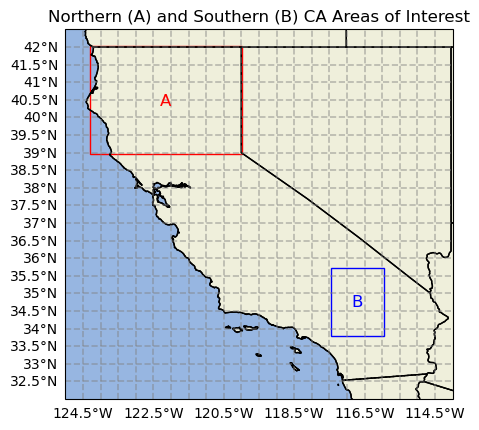

In [32]:
# Coordinates for the bounding boxes
bounding_box1 = [-124.295,38.954,-119.989,42.03]
bounding_box2 = [-117.45, 33.7939, -115.95, 35.7275]

# Calculate the center of each bounding box
center_box1 = [(bounding_box1[0] + bounding_box1[2]) / 2, (bounding_box1[1] + bounding_box1[3]) / 2]
center_box2 = [(bounding_box2[0] + bounding_box2[2]) / 2, (bounding_box2[1] + bounding_box2[3]) / 2]

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=ccrs.PlateCarree())

# Draw the bounding boxes as rectangles
rectangle1 = plt.Rectangle((bounding_box1[0], bounding_box1[1]), bounding_box1[2] - bounding_box1[0], bounding_box1[3] - bounding_box1[1], 
                           fill=False, color='red', transform=ccrs.PlateCarree())
ax.add_patch(rectangle1)

rectangle2 = plt.Rectangle((bounding_box2[0], bounding_box2[1]), bounding_box2[2] - bounding_box2[0], bounding_box2[3] - bounding_box2[1], 
                           fill=False, color='blue', transform=ccrs.PlateCarree())
ax.add_patch(rectangle2)

# Add labels
ax.text(center_box1[0], center_box1[1], 'A', horizontalalignment='center', verticalalignment='center', transform=ccrs.Geodetic(), fontsize=12, color='red')
ax.text(center_box2[0], center_box2[1], 'B', horizontalalignment='center', verticalalignment='center', transform=ccrs.Geodetic(), fontsize=12, color='blue')

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the extent
ax.set_extent([-125, -114, 32, 42.5], crs=ccrs.PlateCarree())  # left, right, bottom, top

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1.2, color='gray', alpha=0.5, linestyle='--', xlocs=range(-180, 181, 1), ylocs=range(-90, 91, 1))
gl.xlocator = plt.FixedLocator([i * 0.5 for i in range(int(-125 * 2), int(-114 * 2) + 1)])  # Setting xlocator for 0.5 degree spacing
gl.ylocator = plt.FixedLocator([i * 0.5 for i in range(int(32 * 2), int(42.5 * 2) + 1)])  # Setting ylocator for 0.5 degree spacing

gl.top_labels = False  # Avoid plotting labels at the top
gl.right_labels = False  # Avoid plotting labels on the right

plt.title('Northern (A) and Southern (B) CA Areas of Interest')
plt.show()

In [10]:
%%time

years = range(2002, 2018)

bbox = [-124.295,38.954,-119.989,42.03]
lon_slice = slice(bbox[0], bbox[2])
lat_slice = slice(bbox[1], bbox[3])
data_subset = data_masked_dropped.sel(longitude=lon_slice, latitude=lat_slice)

time_slices = []

for year in years:
    start_time = f"{year}-02-01T00:00:00"
    end_time = f"{year}-02-28T23:30:00" if year % 4 != 0 else f"{year}-02-29T23:30:00" # Handling leap years
    time_slice = slice(start_time, end_time)
    time_slices.append(time_slice)

# Generate the delayed tasks
day_tasks = [process_year(time_slice, data_subset) for time_slice in time_slices]

# Compute the results
day_results = dask.compute(*day_tasks)

daily_results_all = xr.concat(day_results, dim='year')
daily_results_all['year'] = years

norcal_results_ds = daily_results_all.to_dataset(name='variable') # Need to be converted to Datasets for HVPlot

CPU times: user 2min 28s, sys: 19 s, total: 2min 47s
Wall time: 8min 40s


### 7. Southern California Subset and Calculation

In [11]:
%%time

years = range(2001, 2022)

bbox = [-117.45,33.7939,-115.95,35.7275]
lon_slice = slice(bbox[0], bbox[2])
lat_slice = slice(bbox[1], bbox[3])
data_subset = data_masked_dropped.sel(longitude=lon_slice, latitude=lat_slice)

time_slices = []

for year in years:
    start_time = f"{year}-08-01T00:00:00"
    end_time = f"{year}-08-31T23:30:00"
    time_slice = slice(start_time, end_time)
    time_slices.append(time_slice)

# Generate the delayed tasks
day_tasks = [process_year(time_slice, data_subset) for time_slice in time_slices]

# Compute the results
day_results = dask.compute(*day_tasks)

daily_results_all = xr.concat(day_results, dim='year')
daily_results_all['year'] = years

socal_results_ds = daily_results_all.to_dataset(name='variable') # Need to be converted to Datasets for HVPlot

CPU times: user 1min 1s, sys: 5.9 s, total: 1min 6s
Wall time: 2min 49s


### 8. Plot Northern California Area Averages and Anomalies

In [18]:

mean_vals = norcal_results_ds.mean(dim='year')
std_dev = norcal_results_ds.std(dim='year')

def create_plot(year, std_multiplier):
    # Extract the data for the selected year.
    data_for_year = norcal_results_ds.sel(year=year)

    # Detect anomalies
    high_anomalies = norcal_results_ds.where(data_for_year >= mean_vals + (std_multiplier * std_dev)).sel(year=year)

    # Use hvPlot to create an interactive plot.
    plot = data_for_year.hvplot.line(color='red', label=f'Year {year}') * \
           mean_vals.hvplot.line(color='blue', label='15-Year Daily Mean') * \
           high_anomalies.hvplot.scatter(color='green', marker='^', label='Higher Anomalies')


    return plot.opts(title=f'Northern California Anomaly Detection for Year {year}', legend_position='top_right', xlabel='Day of Month', ylabel='Avg. precipitationCal (mm/hr)', height=400)

# Create Panel widgets for interactive functionality.
year_selector = pn.widgets.Select(name='Select Year', options=list(range(2002, 2018)), value=2017)
std_selector = pn.widgets.FloatSlider(name='Standard Deviation Multiplier for Anomaly', start=1.0, end=3.0, step=0.5, value=2.0)

# Use Panel's 'interact' function, which creates a user interface for exploring the created plot.
pn.interact(create_plot, year=year_selector, std_multiplier=std_selector)


Column(sizing_mode='fixed')
    [0] Column
        [0] Select(options=[2002, 2003, 2004, ...], value=2017)
        [1] FloatSlider(end=3.0, name='Standard Deviation M..., start=1.0, step=0.5, value=2.0)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Overlay, height=400, name='interactive02396', sizing_mode='fixed', width=700)

### 9. Plot Southern California Area Averages and Anomalies

In [28]:
mean_vals = socal_results_ds.mean(dim='year')
std_dev = socal_results_ds.std(dim='year')

def create_plot(year, std_multiplier):
    # Extract the data for the selected year.
    data_for_year = socal_results_ds.sel(year=year)

    # Detect anomalies
    high_anomalies = socal_results_ds.where(data_for_year >= mean_vals + (std_multiplier * std_dev)).sel(year=year)

    # Use hvPlot to create an interactive plot.
    plot = data_for_year.hvplot.line(color='red', label=f'Year {year}') * \
           mean_vals.hvplot.line(color='blue', label='20-Year Daily Mean') * \
           high_anomalies.hvplot.scatter(color='green', marker='^', label='Higher Anomalies')


    return plot.opts(title=f'Southern California Anomaly Detection for Year {year}', legend_position='top_right', xlabel='Day of Month', ylabel='Avg. precipitationCal (mm/hr)', height=400)

# Create Panel widgets for interactive functionality.
year_selector = pn.widgets.Select(name='Select Year', options=list(range(2001,2022)), value=2021)
std_selector = pn.widgets.FloatSlider(name='Standard Deviation Multiplier for Anomaly', start=1.0, end=3.0, step=0.5, value=2.0)

# Use Panel's 'interact' function, which creates a user interface for exploring the created plot.
pn.interact(create_plot, year=year_selector, std_multiplier=std_selector)

Column(sizing_mode='fixed')
    [0] Column
        [0] Select(options=[2001, 2002, 2003, ...], value=2021)
        [1] FloatSlider(end=3.0, name='Standard Deviation M..., start=1.0, step=0.5, value=2.0)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Overlay, height=400, name='interactive20420', sizing_mode='fixed', width=700)

### 10. Plot Anomalies/Year for Both Areas of Interest

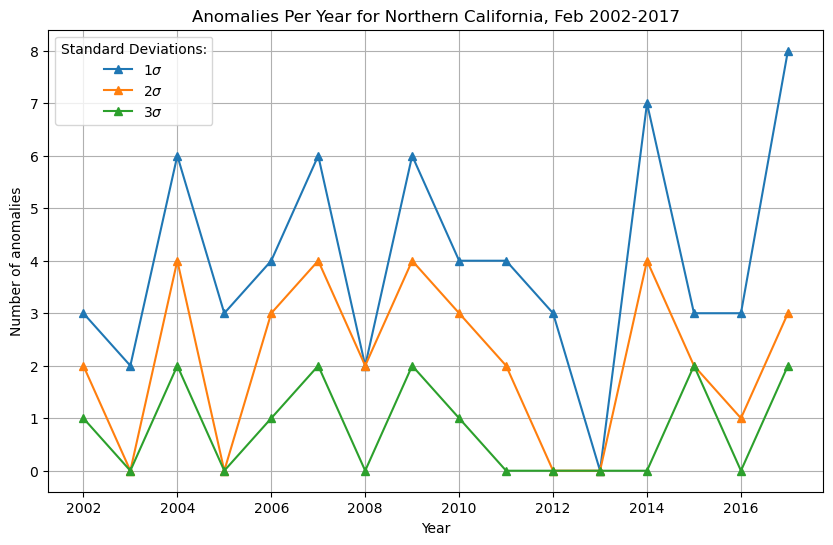

In [23]:
data_var = norcal_results_ds['variable']
mean_vals = data_var.mean(dim='year')
std_dev = data_var.std(dim='year')
years = range(2002, 2018)

# Prepare lists to store the results
anomalies_1 = []
anomalies_2 = []
anomalies_3 = []

for year in years:
    data_for_year = norcal_results_ds.sel(year=year)

    # These conditions check if the values in the data for the year are greater than the threshold (mean + std_dev * multiplier)
    count_1 = norcal_results_ds.where(data_for_year >= mean_vals + (1 * std_dev)).sel(year=year)['variable'].values
    count_2 = norcal_results_ds.where(data_for_year >= mean_vals + (2 * std_dev)).sel(year=year)['variable'].values
    count_3 = norcal_results_ds.where(data_for_year >= mean_vals + (3 * std_dev)).sel(year=year)['variable'].values

    # Append the counts to the respective lists
    anomalies_1.append(np.count_nonzero(~np.isnan(count_1)))
    anomalies_2.append(np.count_nonzero(~np.isnan(count_2)))
    anomalies_3.append(np.count_nonzero(~np.isnan(count_3)))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(years, anomalies_1, label='$1\\sigma$', marker='^')
plt.plot(years, anomalies_2, label='$2\\sigma$', marker='^')
plt.plot(years, anomalies_3, label='$3\\sigma$', marker='^')

plt.title('Anomalies Per Year for Northern California, Feb 2002-2017')
plt.xlabel('Year')
plt.ylabel('Number of anomalies')
plt.legend(title='Standard Deviations:')
plt.grid(True)
plt.show()

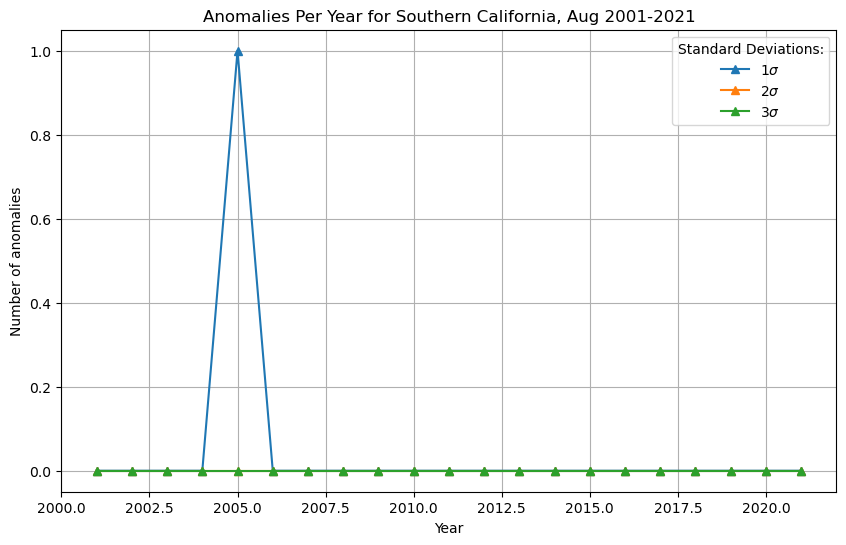

In [29]:
data_var = norcal_results_ds['variable']
mean_vals = data_var.mean(dim='year')
std_dev = data_var.std(dim='year')
years = range(2001, 2022)

# Prepare lists to store the results
anomalies_1 = []
anomalies_2 = []
anomalies_3 = []

for year in years:
    data_for_year = socal_results_ds.sel(year=year)

    # These conditions check if the values in the data for the year are greater than the threshold (mean + std_dev * multiplier)
    count_1 = socal_results_ds.where(data_for_year >= mean_vals + (1 * std_dev)).sel(year=year)['variable'].values
    count_2 = socal_results_ds.where(data_for_year >= mean_vals + (2 * std_dev)).sel(year=year)['variable'].values
    count_3 = socal_results_ds.where(data_for_year >= mean_vals + (3 * std_dev)).sel(year=year)['variable'].values

    # Append the counts to the respective lists
    anomalies_1.append(np.count_nonzero(~np.isnan(count_1)))
    anomalies_2.append(np.count_nonzero(~np.isnan(count_2)))
    anomalies_3.append(np.count_nonzero(~np.isnan(count_3)))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(years, anomalies_1, label='$1\\sigma$', marker='^')
plt.plot(years, anomalies_2, label='$2\\sigma$', marker='^')
plt.plot(years, anomalies_3, label='$3\\sigma$', marker='^')

plt.title('Anomalies Per Year for Southern California, Aug 2001-2021')
plt.xlabel('Year')
plt.ylabel('Number of anomalies')
plt.legend(title='Standard Deviations:')
plt.grid(True)
plt.show()